# ABO

In [1]:
options(readr.num_columns = 0, tidyverse.quiet = T)

library(lubridate)
library(tidyverse)


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



In [2]:
con <- DBI::dbConnect(
    RMySQL::MySQL(), 
    host = "localhost",
    user = "mnz2108",
    dbname = "clinical_merge_v5_240919",
    password = read_file('../mysql_password.txt') %>% str_replace('\n', '')
)

# DBI::dbListTables(con)

date = '2020-04-05'

covid_test_results <- con %>% tbl("1_covid_test_results_cuimc") %>%
    filter(date_retrieved == date)

condition <- con %>% tbl("condition_occurrence")
measurement <- con %>% tbl("measurement")

concept_ancestor <- con %>% tbl("concept_ancestor")
concept <- con %>% tbl("concept")

covid_nyp_person <- con %>% tbl("1_covid_patients_noname") %>% 
    filter(date_retrieved == date)
covid_person <- con %>% tbl("1_covid_persons")

covid_nyp_measurements <- con %>% tbl("1_covid_measurements_noname") %>% 
    filter(date_retrieved == date)

covid_nyp_intubation <- con %>% tbl("1_covid_intubation_orders_noname") %>% 
    filter(date_retrieved == date)

covid_nyp_test_results <- con %>% tbl("1_covid_labs_noname") %>% 
    filter(date_retrieved == date)

covid_p2p <- con %>% tbl("1_covid_patient2person")
cumc_map <- con %>% tbl("cumc_patient_mappings")

Warning message in .local(conn, statement, ...):
“unrecognized MySQL field type 7 in column 4 imported as character”Warning message in .local(conn, statement, ...):
“unrecognized MySQL field type 7 in column 6 imported as character”Warning message in .local(conn, statement, ...):
“unrecognized MySQL field type 7 in column 4 imported as character”Warning message in .local(conn, statement, ...):
“Decimal MySQL column 8 imported as numeric”Warning message in .local(conn, statement, ...):
“Decimal MySQL column 11 imported as numeric”Warning message in .local(conn, statement, ...):
“Decimal MySQL column 12 imported as numeric”Warning message in .local(conn, statement, ...):
“Unsigned INTEGER in col 0 imported as numeric”Warning message in .local(conn, statement, ...):
“Unsigned INTEGER in col 0 imported as numeric”

# Subsetting all NYP data

## COVID infection test results

In [3]:
covid_test_formatted <- covid_nyp_test_results %>% 
    filter(comment_id == 36072) %>%
    select(pat_mrn_id, sex, birth_date, death_date, 
           covid_result_datetime = result_datetime, covid_result = ord_value)    
#     filter(comment_id == 36195 | comment_id == 36074) # <- these others have only 2 pts per.

## Intubated individuals (all NYP data)

In [4]:
covid_intubation_formatted <- covid_nyp_intubation %>%
    select(pat_mrn_id, intubation_order_date = order_date, 
           intubation_description = description, intubation_display_name = display_name)

## Assign blood types

Can use data from both `measurement` table (up to 2019 CUIMC data) and `1_covid_measurements_noname`, COVID-specific measurements from all NYP.

measurement_concept_id = 3045765 (http://athena.ohdsi.org/search-terms/terms/3045765)

In [5]:
covid_blood_type_formatted <- union_all(
    # Blood types from COVID NYP table (Only January 2020 and later)
    covid_nyp_measurements %>%
        filter(component_name %>% str_detect('ABORH') & ord_value != 'Invalid') %>%
        select(pat_mrn_id, blood_type_value = ord_value) %>%
        distinct(),
    
    # Blood types from measurement table (before January 2020)
    measurement %>%
        filter(measurement_concept_id == 3045765 & value_source_value != "Invalid") %>%
        select(person_id, value_source_value) %>%
        inner_join(covid_p2p, by = 'person_id') %>%
        select(pat_mrn_id, blood_type_value = value_source_value) %>%
        distinct()
)

In [6]:
# Find individuals with multiple distinct blood type measurements
# Almost all of these are like 'A Rh Positive' and 'A Positive'
multiple_blood_types_df <- covid_blood_type_formatted %>%
    group_by(pat_mrn_id) %>%
    summarize(num = n_distinct(blood_type_value)) %>%
    filter(num > 1) %>%
    ungroup %>%

    distinct(pat_mrn_id) %>%
    inner_join(covid_blood_type_formatted, by = 'pat_mrn_id') %>%
    as_tibble %>%
    mutate(
        abo = blood_type_value %>% str_extract('^[ABO]+'),
        rh = blood_type_value %>% str_to_lower %>% str_extract('pos|neg')
    ) %>%
    group_by(pat_mrn_id) %>%
    mutate(num = n_distinct(abo, rh)) %>%
    ungroup %>%
    filter(num > 1)
    
multiple_blood_types_df %>% distinct(pat_mrn_id) %>% nrow %>% print

multiple_blood_types_df %>% head(0)

[1] 1


pat_mrn_id,blood_type_value,abo,rh,num
<int>,<chr>,<chr>,<chr>,<int>


## Combine test results, blood type, intubation, death

In [7]:
full_df <- covid_test_formatted %>%
    left_join(covid_blood_type_formatted, by = 'pat_mrn_id') %>%
    left_join(covid_intubation_formatted, by = 'pat_mrn_id') %>%
    as_tibble %>%
    anti_join(multiple_blood_types_df %>% distinct(pat_mrn_id), 
              by = 'pat_mrn_id')

full_df %>% head(0)

pat_mrn_id,sex,birth_date,death_date,covid_result_datetime,covid_result,blood_type_value,intubation_order_date,intubation_description,intubation_display_name
<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>


## Clean to ease production of contingency tables

In [8]:
final_formatted_df <- full_df %>% 
    mutate(
        covid_result_binary = (covid_result == 'Detected') %>% as.integer,
        intubation_binary = (!is.na(intubation_description) & 
                             !is.na(intubation_order_date) &
                             !is.na(intubation_display_name)) %>% as.integer,
        died_binary = (death_date != '0000-00-00') %>% as.integer,
        
        abo = blood_type_value %>% str_extract('^[ABO]+'),
        rh = blood_type_value %>% str_to_lower %>% str_extract('neg|pos'),
        
        birth_date = ymd(birth_date),
        age = interval(birth_date, ymd(date)) %>% time_length("years")
    ) %>%
    
    # Remove duplicate blood types, covid results
    select(pat_mrn_id, sex, age, abo, rh, covid_result_binary, intubation_binary, died_binary) %>%
    distinct() %>%

    # Call anyone with a COVID+ test (ever) a COVID+ case
    group_by(pat_mrn_id, sex, age, abo, rh, intubation_binary, died_binary) %>%
    summarize(covid_result_binary = sum(covid_result_binary)) %>%
    ungroup %>%

    # Remove obvious error
    filter(pat_mrn_id != 0) %>%

    # Fill NA with relevant values
    replace_na(list(
        abo = 'unknown',
        rh = 'unknown'
    ))

final_formatted_df %>% head(0)

pat_mrn_id,sex,age,abo,rh,intubation_binary,died_binary,covid_result_binary
<int>,<int>,<dbl>,<chr>,<chr>,<int>,<int>,<int>


### General population blood group frequencies

In [9]:
print_num_remove_contradictory <- function(df) {
    df %>%
        filter(num > 1) %>%
        distinct(person_id) %>%
        nrow %>%
        print
    
    df %>%
        filter(num == 1)
}

In [10]:
general_population_blood_group_measurements <- measurement %>%
    filter(measurement_concept_id == 3045765 & value_source_value != "Invalid") %>%

    # Remove individuals tested for COVID
    anti_join(
        covid_nyp_test_results %>%
            inner_join(covid_p2p, by = 'pat_mrn_id'),
        by = 'person_id'
    ) %>%
    
    # Remove duplicate values
    select(person_id, value_source_value, measurement_date) %>%
    distinct() %>%
    as_tibble() %>%

    # Reformat 'A Rh Positive' and 'A Positive' to same coding
    mutate(
        abo = value_source_value %>% str_extract('^[ABO]+'),
        rh = value_source_value %>% str_to_lower %>% str_extract('neg|pos'),
    ) %>%
    filter(!is.na(abo) & !is.na(rh)) %>%
    distinct(person_id, abo, rh, .keep_all = T) %>%

    group_by(person_id) %>%
    mutate(num = n()) %>%
    ungroup %>%
    print_num_remove_contradictory

general_population_blood_group_frequencies <- general_population_blood_group_measurements %>%
    group_by(abo, rh) %>%
    summarize(num_general = n()) %>%
    ungroup

general_population_blood_group_frequencies

[1] 114


abo,rh,num_general
<chr>,<chr>,<int>
A,neg,3447
A,pos,32196
AB,neg,394
AB,pos,4188
B,neg,1422
B,pos,14807
O,neg,4808
O,pos,47598


In [11]:
counts_df <- final_formatted_df %>%
    group_by(abo, rh) %>%
    summarize(
        intubation_binary_covid_pos = sum(intubation_binary & covid_result_binary), 
        intubation_binary = sum(intubation_binary),
        died_binary_covid_pos = sum(died_binary & covid_result_binary),
        died_binary = sum(died_binary),
        covid_result_binary = sum(covid_result_binary),
        total_tested = n()
    ) %>%
    ungroup %>%
    left_join(general_population_blood_group_frequencies, by = c('abo', 'rh'))

counts_df

abo,rh,intubation_binary_covid_pos,intubation_binary,died_binary_covid_pos,died_binary,covid_result_binary,total_tested,num_general
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
A,neg,2,14,1,2,17,43,3447
A,pos,60,119,26,44,216,435,32196
AB,neg,0,3,0,0,0,5,394
AB,pos,8,19,5,8,21,63,4188
B,neg,2,6,0,1,7,21,1422
B,pos,33,59,12,20,109,231,14807
O,neg,4,10,0,3,21,47,4808
O,pos,70,157,36,56,291,714,47598
unknown,unknown,92,121,64,73,2110,3463,NA


## QC

In [12]:
final_formatted_df %>%
    summarize_all(.funs = function(col) sum(is.na(col)))

pat_mrn_id,sex,age,abo,rh,intubation_binary,died_binary,covid_result_binary
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0


In [13]:
# No duplicate individuals
final_formatted_df %>%
    summarize(n(), n_distinct(pat_mrn_id))

n(),n_distinct(pat_mrn_id)
<int>,<int>
5022,5022


In [14]:
# Many COVID- are intubated... seems potentially suspicious.
final_formatted_df %>%
    mutate(
        negative_intubated = ((covid_result_binary == 0) & (intubation_binary == 1)) %>% as.integer
    ) %>%
    summarize(
        num_negative_intubated = sum(negative_intubated),
        num_intubated = sum(intubation_binary),
        num_negative = sum(covid_result_binary == 0),
        num_total = n()
    )

num_negative_intubated,num_intubated,num_negative,num_total
<int>,<int>,<int>,<int>
237,508,2230,5022


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


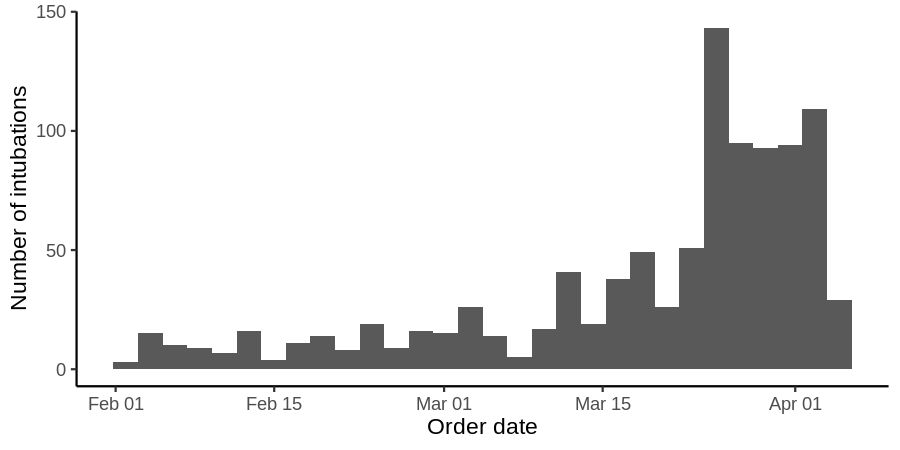

In [15]:
options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.res = 150)

# Specific intubation orders for covid negative individuals
# final_formatted_df %>%
#     filter(intubation_binary == 1 & covid_result_binary == 0) %>%
#     select(pat_mrn_id) %>%
#     inner_join(covid_nyp_intubation %>% as_tibble, by = 'pat_mrn_id')


covid_nyp_intubation %>%
    select(order_date) %>%
    as_tibble() %>%
    mutate(order_date = order_date %>% ymd()) %>%
    ggplot(aes(x = order_date)) + 
    geom_histogram() +
    theme_classic() +
    ylab('Number of intubations') +
    xlab('Order date')

# Perform tests

In [16]:
chisq_complete <- function(contingency, comparisons) {
    all_tests_df <- data.frame()
    for (comparison in names(comparisons)) {
        all_tests_df <- all_tests_df %>%
            bind_rows(
                contingency %>%
                    select(choices = comparisons[comparison] %>% unlist) %>%
                    chisq.test %>%
                    broom::tidy() %>%
                    mutate(comparison = comparison)
            )
    }
    all_tests_df
}

individual_fisher_exact <- function(contingency, comparisons, blood_groups) {
    all_tests_df <- data.frame()
    for (group in blood_groups) {
        one_vs_rest_contingency <- contingency %>%
            mutate(
                has_this = (blood_group == group) %>% 
                               as.character %>% 
                               recode_factor('TRUE' = group, 
                                      'FALSE' = str_glue('non-{group}') %>% as.character)
            )  %>%
            select(-blood_group) %>%
            group_by(has_this) %>%
            summarize_all(sum) %>%
            ungroup

        for (comparison in names(comparisons)) {
            all_tests_df <- all_tests_df %>%
                bind_rows(
                    one_vs_rest_contingency %>%
                        select(choices = comparisons[comparison] %>% unlist) %>%
                        fisher.test %>%
                        broom::tidy() %>%
                        mutate(
                            blood_group = group,
                            comparison = comparison
                        )
                )
        }
    }
    all_tests_df %>%
        select(blood_group, comparison, method, alternative, estimate, 
               conf.low, conf.high, p.value)
}

# ABO 

In [17]:
abo_contingency <- counts_df %>%
    filter(abo != 'unknown') %>%
    group_by(abo) %>%
    summarize(
        intubated = sum(intubation_binary), 
        intubated_covid_positive = sum(intubation_binary_covid_pos),
        died_covid_positive = sum(died_binary_covid_pos),
        died = sum(died_binary),
        covid_positive = sum(covid_result_binary),
        total_tested = sum(total_tested),
        general_pop = sum(num_general)
    ) %>%
    ungroup %>%
    rename(blood_group = abo) %>%
    mutate(
        covid_negative = total_tested - covid_positive,
        not_intubated = total_tested - intubated,
        not_intubated_covid_positive = covid_positive - intubated_covid_positive,
        alive = total_tested - died,
        alive_covid_positive = covid_positive - died_covid_positive
    ) %>%
    select(blood_group, covid_positive, covid_negative, intubated, not_intubated, 
           intubated_covid_positive, not_intubated_covid_positive, died, alive, 
           died_covid_positive, alive_covid_positive, general_pop)

abo_contingency

blood_group,covid_positive,covid_negative,intubated,not_intubated,intubated_covid_positive,not_intubated_covid_positive,died,alive,died_covid_positive,alive_covid_positive,general_pop
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
A,233,245,133,345,62,171,46,432,27,206,35643
AB,21,47,22,46,8,13,8,60,5,16,4582
B,116,136,65,187,35,81,21,231,12,104,16229
O,312,449,167,594,74,238,59,702,36,276,52406


In [18]:
comparisons <- list(
    'positive_vs_general' = c('covid_positive', 'general_pop'),
    'positive_vs_negative' = c('covid_positive', 'covid_negative'),
    'intubated_covid_positive_vs_not_intubated_covid_positive' = c('intubated_covid_positive', 
                                                                   'not_intubated_covid_positive'),
    'died_covid_positive_vs_alive_covid_positive' = c('died_covid_positive', 'alive_covid_positive')
)
abo_blood_groups <- abo_contingency %>% pull(blood_group)

# Chi-square tests for each comparison to see if blood group distributions are
# equivalent between the comparison groups
abo_association_tests_df <- chisq_complete(abo_contingency, comparisons)

# Fisher's exact tests for each blood group vs all others against the outcome
abo_one_vs_rest_tests_df <- individual_fisher_exact(abo_contingency, 
                                                    comparisons, 
                                                    abo_blood_groups)

Warning message in chisq.test(.):
“Chi-squared approximation may be incorrect”

# ABO+Rh

Here, we've removed AB- by requring that more than 5 individuals with each blood type have been tested for COVID.

In [19]:
abo_rh_contingency <- counts_df %>%
    filter(abo != 'unknown') %>%
    unite('blood_group', c(abo, rh), sep = '-') %>%
    rename(
        intubated = intubation_binary,
        intubated_covid_positive = intubation_binary_covid_pos,
        died = died_binary,
        died_covid_positive = died_binary_covid_pos,
        covid_positive = covid_result_binary,
        general_pop = num_general
    ) %>%
    mutate(
        covid_negative = total_tested - covid_positive,
        not_intubated = total_tested - intubated,
        not_intubated_covid_positive = covid_positive - intubated_covid_positive,
        alive = total_tested - died,
        alive_covid_positive = covid_positive - died_covid_positive
    ) %>%
    select(blood_group, covid_positive, covid_negative, intubated, not_intubated, 
           intubated_covid_positive, not_intubated_covid_positive, died, alive, 
           died_covid_positive, alive_covid_positive, general_pop, total_tested)


abo_rh_test_contingency <- abo_rh_contingency %>% filter(total_tested > 5)

abo_rh_contingency

blood_group,covid_positive,covid_negative,intubated,not_intubated,intubated_covid_positive,not_intubated_covid_positive,died,alive,died_covid_positive,alive_covid_positive,general_pop,total_tested
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
A-neg,17,26,14,29,2,15,2,41,1,16,3447,43
A-pos,216,219,119,316,60,156,44,391,26,190,32196,435
AB-neg,0,5,3,2,0,0,0,5,0,0,394,5
AB-pos,21,42,19,44,8,13,8,55,5,16,4188,63
B-neg,7,14,6,15,2,5,1,20,0,7,1422,21
B-pos,109,122,59,172,33,76,20,211,12,97,14807,231
O-neg,21,26,10,37,4,17,3,44,0,21,4808,47
O-pos,291,423,157,557,70,221,56,658,36,255,47598,714


In [20]:
comparisons <- list(
    'positive_vs_general' = c('covid_positive', 'general_pop'),
    'positive_vs_negative' = c('covid_positive', 'covid_negative'),
    'intubated_covid_positive_vs_not_intubated_covid_positive' = c('intubated_covid_positive', 
                                                                   'not_intubated_covid_positive'),
    'died_covid_positive_vs_alive_covid_positive' = c('died_covid_positive', 'alive_covid_positive')
)
abo_rh_blood_groups <- abo_rh_test_contingency %>% pull(blood_group)

# Chi-square tests for each comparison to see if blood group distributions are
# equivalent between the comparison groups
abo_rh_association_tests_df <- chisq_complete(abo_rh_test_contingency, comparisons)

# Fisher's exact tests for each blood group vs all others against the outcome
abo_rh_one_vs_rest_tests_df <- individual_fisher_exact(abo_rh_test_contingency, 
                                                        comparisons, 
                                                        abo_rh_blood_groups)

Warning message in chisq.test(.):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(.):
“Chi-squared approximation may be incorrect”

# Zhao 2019 medrXiv

https://www.medrxiv.org/content/10.1101/2020.03.11.20031096v1

In [21]:
zhao_contingency <- data.frame(
    blood_group = c('A', 'B', 'AB', 'O'),
    wuhan_controls = c(1188, 920, 336, 1250),
    wuhan_jinyintan_pts = c(670, 469, 178, 458),
    wuhan_jinyintan_died = c(85, 50, 19, 52),
    wuhan_renmin_pts = c(45, 25, 15, 28),
    shenzhen_controls = c(6728, 5880, 1712, 9066),
    shenzhen_pts = c(82, 83, 39, 81)
)


abo_zhao_contingency <- abo_contingency %>%
    select(blood_group, nyp_covid_positive = covid_positive, 
           nyp_covid_negative = covid_negative, nyp_general_pop = general_pop) %>%
    inner_join(zhao_contingency, by = 'blood_group')

abo_zhao_contingency

Warning message:
“Column `blood_group` joining character vector and factor, coercing into character vector”

blood_group,nyp_covid_positive,nyp_covid_negative,nyp_general_pop,wuhan_controls,wuhan_jinyintan_pts,wuhan_jinyintan_died,wuhan_renmin_pts,shenzhen_controls,shenzhen_pts
<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A,233,245,35643,1188,670,85,45,6728,82
AB,21,47,4582,336,178,19,15,1712,39
B,116,136,16229,920,469,50,25,5880,83
O,312,449,52406,1250,458,52,28,9066,81


In [22]:
# Format table for manuscript
abo_zhao_contingency %>% 
    select(blood_group, nyp_covid_positive, nyp_general_pop, shenzhen_pts, shenzhen_controls, 
           wuhan_jinyintan_pts, wuhan_renmin_pts, wuhan_controls) %>%
    mutate(
        nyp_general_pop_frac = (nyp_general_pop / sum(nyp_general_pop)) %>% round(3),
        shenzhen_controls_frac = (shenzhen_controls / sum(shenzhen_controls)) %>% round(3),
        wuhan_controls_frac = (wuhan_controls / sum(wuhan_controls)) %>% round(3),        
        "NYP general population" = str_glue('{100 * nyp_general_pop_frac}% ({nyp_general_pop})') %>%
            as.character,        
        "Shenzhen general population" = str_glue('{100 * shenzhen_controls_frac}% ({shenzhen_controls})') %>%
            as.character,
        "Wuhan general population" = str_glue('{100 * wuhan_controls_frac}% ({wuhan_controls})') %>%
            as.character,       
        
        nyp_covid_positive_frac = (nyp_covid_positive / sum(nyp_covid_positive)) %>% round(3),
        shenzhen_covid_positive_frac = (shenzhen_pts / sum(shenzhen_pts)) %>% round(3),
        wuhan_jin_covid_positive_frac = (wuhan_jinyintan_pts / sum(wuhan_jinyintan_pts)) %>% round(3),
        wuhan_ren_covid_positive_frac = (wuhan_renmin_pts / sum(wuhan_renmin_pts)) %>% round(3),
        
        "NYP COV+" = str_glue('{100 * nyp_covid_positive_frac}% ({nyp_covid_positive})') %>% as.character,
        "Shenzhen COV+" = str_glue('{100 * shenzhen_covid_positive_frac}% ({shenzhen_pts})') %>% as.character,
        "Wuhan Jinyintan COV+" = str_glue('{100 * wuhan_jin_covid_positive_frac}% ({wuhan_jinyintan_pts})') %>% as.character,
        "Wuhan Renmin COV+" = str_glue('{100 * wuhan_ren_covid_positive_frac}% ({wuhan_renmin_pts})') %>% as.character,
    ) %>%
    select("Blood group" = blood_group, "NYP general population", "NYP COV+",
           "Shenzhen general population", "Shenzhen COV+", "Wuhan general population",
           "Wuhan Jinyintan COV+", "Wuhan Renmin COV+") %>%
    knitr::kable()



|Blood group |NYP general population |NYP COV+    |Shenzhen general population |Shenzhen COV+ |Wuhan general population |Wuhan Jinyintan COV+ |Wuhan Renmin COV+ |
|:-----------|:----------------------|:-----------|:---------------------------|:-------------|:------------------------|:--------------------|:-----------------|
|A           |32.7% (35643)          |34.2% (233) |28.8% (6728)                |28.8% (82)    |32.2% (1188)             |37.7% (670)          |39.8% (45)        |
|AB          |4.2% (4582)            |3.1% (21)   |7.3% (1712)                 |13.7% (39)    |9.1% (336)               |10% (178)            |13.3% (15)        |
|B           |14.9% (16229)          |17% (116)   |25.1% (5880)                |29.1% (83)    |24.9% (920)              |26.4% (469)          |22.1% (25)        |
|O           |48.1% (52406)          |45.7% (312) |38.8% (9066)                |28.4% (81)    |33.8% (1250)             |25.8% (458)          |24.8% (28)        |

In [23]:
bind_rows(
    abo_zhao_contingency %>%
        select(nyp_general_pop, shenzhen_controls) %>%
        chisq.test %>% 
        broom::tidy() %>%
        mutate(comparison = 'nyp_general_pop_vs_shenzhen_controls'),
    abo_zhao_contingency %>%
        select(nyp_general_pop, wuhan_controls) %>%
        chisq.test %>%
        broom::tidy() %>%
        mutate(comparison = 'nyp_general_pop_vs_wuhan_controls')
)

statistic,p.value,parameter,method,comparison
<dbl>,<dbl>,<int>,<chr>,<chr>
2056.5982,0.000000e+00,3,Pearson's Chi-squared test,nyp_general_pop_vs_shenzhen_controls
583.2884,4.228296e-126,3,Pearson's Chi-squared test,nyp_general_pop_vs_wuhan_controls


In [24]:
abo_zhao_contingency %>%
        select(nyp_general_pop, shenzhen_controls) %>% 
chisq.test


	Pearson's Chi-squared test

data:  .
X-squared = 2056.6, df = 3, p-value < 2.2e-16


In [25]:
abo_zhao_contingency %>%
    select(nyp_general_pop, wuhan_controls) %>%
    chisq.test


	Pearson's Chi-squared test

data:  .
X-squared = 583.29, df = 3, p-value < 2.2e-16


#### Meta-analysis with random effects

Can't find any way to extract the pooled effects, so this must be done by hand.

In [26]:
binarize_contingency <- function(contingency, target_blood_group) {
    contingency %>%
        mutate(
            blood_group = (blood_group == target_blood_group) %>% 
                as.character %>%
                recode_factor("TRUE" = 'target', 
                              "FALSE" = 'non_target')
        ) %>%
        group_by(blood_group) %>%
        summarize_all(sum) %>%
        ungroup
}

make_comparison_table <- function(target_blood_group) {
    meta_table <- abo_zhao_contingency %>%
        binarize_contingency(target_blood_group)

    covid_target <- meta_table %>% 
        filter(blood_group == 'target') %>%
        select(
            'nyp' = nyp_covid_positive, 
            'wuhan_jinyintain' = wuhan_jinyintan_pts,
            'wuhan_renmin' = wuhan_renmin_pts,
            'shenzhen' = shenzhen_pts
        ) %>%
        unlist

    covid_total <- meta_table %>%
        select(
            'nyp' = nyp_covid_positive, 
            'wuhan_jinyintain' = wuhan_jinyintan_pts,
            'wuhan_renmin' = wuhan_renmin_pts,
            'shenzhen' = shenzhen_pts
        ) %>%
        summarize_all(sum) %>%
        unlist

    general_target <- meta_table %>%
        filter(blood_group == 'target') %>%
        mutate(wuhan_control_copy = wuhan_controls) %>%
        select(
            'nyp' = nyp_general_pop, 
            'wuhan_jinyintain' = wuhan_controls,
            'wuhan_renmin' = wuhan_control_copy,
            'shenzhen' = shenzhen_controls
        ) %>%
        unlist

    general_total <- meta_table %>% 
        mutate(wuhan_control_copy = wuhan_controls) %>%
        select(
            'nyp' = nyp_general_pop, 
            'wuhan_jinyintain' = wuhan_controls,
            'wuhan_renmin' = wuhan_control_copy,
            'shenzhen' = shenzhen_controls
        ) %>%
        summarize_all(sum) %>%
        unlist

    cbind(covid_target, covid_total, general_target, general_total) %>%
        as.data.frame %>%
        rownames_to_column('site')
}

In [27]:
do_meta_analysis <- function(blood_group) {
    meta_result <- meta::metabin(
        event.e = covid_target,
        n.e = covid_total, 
        event.c = general_target, 
        n.c = general_total,
        studlab = site,
        data = make_comparison_table(blood_group),
        comb.random = T,
        comb.fixed = F,
        sm = 'OR'
    )
    meta_result
}

In [28]:
do_meta_analysis('A')

                     OR           95%-CI %W(random)
nyp              1.0660 [0.9095; 1.2494]       31.8
wuhan_jinyintain 1.2790 [1.1364; 1.4395]       39.3
wuhan_renmin     1.3959 [0.9519; 2.0472]       10.3
shenzhen         1.0001 [0.7727; 1.2945]       18.6

Number of studies combined: k = 4

                         OR           95%-CI    z p-value
Random effects model 1.1636 [1.0155; 1.3333] 2.18  0.0291

Quantifying heterogeneity:
 tau^2 = 0.0086; tau = 0.0928; I^2 = 47.1% [0.0%; 82.4%]; H = 1.38 [1.00; 2.39]

Test of heterogeneity:
    Q d.f. p-value
 5.67    3  0.1287

Details on meta-analytical method:
- Mantel-Haenszel method
- DerSimonian-Laird estimator for tau^2
- Mantel-Haenszel estimator used in calculation of Q and tau^2 (like RevMan 5)

In [29]:
do_meta_analysis('B')

                     OR           95%-CI %W(random)
nyp              1.1698 [0.9573; 1.4294]       23.7
wuhan_jinyintain 1.0828 [0.9516; 1.2321]       57.1
wuhan_renmin     0.8566 [0.5460; 1.3440]        4.7
shenzhen         1.2233 [0.9458; 1.5822]       14.4

Number of studies combined: k = 4

                         OR           95%-CI    z p-value
Random effects model 1.1101 [1.0068; 1.2240] 2.10  0.0361

Quantifying heterogeneity:
 tau^2 = 0; tau = 0; I^2 = 0.0% [0.0%; 79.4%]; H = 1.00 [1.00; 2.20]

Test of heterogeneity:
    Q d.f. p-value
 2.23    3  0.5268

Details on meta-analytical method:
- Mantel-Haenszel method
- DerSimonian-Laird estimator for tau^2
- Mantel-Haenszel estimator used in calculation of Q and tau^2 (like RevMan 5)

In [30]:
do_meta_analysis('AB')

                     OR           95%-CI %W(random)
nyp              0.7230 [0.4678; 1.1176]       23.5
wuhan_jinyintain 1.1139 [0.9201; 1.3487]       30.2
wuhan_renmin     1.5297 [0.8783; 2.6643]       20.0
shenzhen         2.0071 [1.4266; 2.8237]       26.3

Number of studies combined: k = 4

                         OR           95%-CI    z p-value
Random effects model 1.2519 [0.8384; 1.8694] 1.10  0.2721

Quantifying heterogeneity:
 tau^2 = 0.1289; tau = 0.3591; I^2 = 80.6% [48.9%; 92.6%]; H = 2.27 [1.40; 3.68]

Test of heterogeneity:
     Q d.f. p-value
 15.43    3  0.0015

Details on meta-analytical method:
- Mantel-Haenszel method
- DerSimonian-Laird estimator for tau^2
- Mantel-Haenszel estimator used in calculation of Q and tau^2 (like RevMan 5)

In [31]:
do_meta_analysis('O')

                     OR           95%-CI %W(random)
nyp              0.9084 [0.7810; 1.0566]       31.1
wuhan_jinyintain 0.6799 [0.5993; 0.7715]       32.9
wuhan_renmin     0.6441 [0.4179; 0.9925]       13.2
shenzhen         0.6272 [0.4842; 0.8124]       22.8

Number of studies combined: k = 4

                         OR           95%-CI     z p-value
Random effects model 0.7252 [0.5971; 0.8807] -3.24  0.0012

Quantifying heterogeneity:
 tau^2 = 0.0257; tau = 0.1603; I^2 = 72.1% [21.0%; 90.2%]; H = 1.89 [1.12; 3.19]

Test of heterogeneity:
     Q d.f. p-value
 10.76    3  0.0131

Details on meta-analytical method:
- Mantel-Haenszel method
- DerSimonian-Laird estimator for tau^2
- Mantel-Haenszel estimator used in calculation of Q and tau^2 (like RevMan 5)

In [32]:
# Couldn't find a way to easily tidy these results, so making the df manually.
meta_pooled_effects_df <- data.frame(
    blood_group = c('A', 'B', 'AB', 'O'),
    OR = c(1.1636, 1.1101, 1.2519, 0.7252),
    CI = c('1.0155 - 1.3333', '1.0068 - 1.2240', '0.8384 - 1.8694', '0.5971 - 0.8807'),
    p_value = c(0.0291, 0.0361, 0.2721, 0.0012)
)

meta_pooled_effects_df

blood_group,OR,CI,p_value
<fct>,<dbl>,<fct>,<dbl>
A,1.1636,1.0155 - 1.3333,0.0291
B,1.1101,1.0068 - 1.2240,0.0361
AB,1.2519,0.8384 - 1.8694,0.2721
O,0.7252,0.5971 - 0.8807,0.0012


# Multivariate analysis

In [33]:
get_sql_descendants <- function(ancestor_concept_id, field, table) {
    # Gets COVID table individuals having any codes belonging to descendants
    # of the ancestor code
    
    
    sql_string <- str_glue("
SELECT DISTINCT relevant_occurrences.person_id, relevant_occurrences.pat_mrn_id
FROM (
    SELECT descendant_concept_id
    FROM concept_ancestor
    WHERE ancestor_concept_id={ancestor_concept_id}
) AS relevant_concepts
INNER JOIN (
    SELECT 1_covid_patient2person.person_id, 1_covid_patient2person.pat_mrn_id, {field}
    FROM {table}
    INNER JOIN 1_covid_patient2person
        ON {table}.person_id=1_covid_patient2person.person_id
) AS relevant_occurrences
    ON relevant_concepts.descendant_concept_id=relevant_occurrences.{field}
") %>% as.character
}

# Hypertension - all descendants -f condition_concept_id 316866
hypertension <- con %>% 
    tbl(sql(
        get_sql_descendants(316866, 'condition_concept_id', 'condition_occurrence')
    ))

# Respiratory disorders - all descendants of condition_concept_id 320136
respiratory_disorders <- con %>% 
    tbl(sql(
        get_sql_descendants(320136, 'condition_concept_id', 'condition_occurrence')
    ))

# Cardiovascular disorders - all descendants of condition_concept_id 134057
cardiovascular_disorders <- con %>% 
    tbl(sql(
        get_sql_descendants(134057, 'condition_concept_id', 'condition_occurrence')
    ))


# Diabetes mellitus - all descendants of condition_concept_id 201820
diabetes <- con %>% 
    tbl(sql(
        get_sql_descendants(201820, 'condition_concept_id', 'condition_occurrence')
    ))

# Overweight - all descendants of observation_concept_id 437525
overweight <- con %>% 
    tbl(sql(
        get_sql_descendants(437525, 'observation_concept_id', 'observation')
    ))

combined_risk_factors <- bind_rows(
    hypertension %>%
        mutate(phenotype = 'hypertension') %>%
        as_tibble(),
    cardiovascular_disorders %>%
        mutate(phenotype = 'cv_diseases') %>%
        as_tibble(),
    respiratory_disorders %>% 
        mutate(phenotype = 'resp_diseases') %>%
        as_tibble(),
    diabetes %>% 
        mutate(phenotype = 'diabetes') %>%
        as_tibble(),
    overweight %>% 
        mutate(phenotype = 'overweight') %>%
        as_tibble()
)

combined_risk_factors %>% group_by(phenotype) %>% tally

phenotype,n
<chr>,<int>
cv_diseases,2180
diabetes,958
hypertension,1620
overweight,369
resp_diseases,2082


In [34]:
abo_multivariate_df <- final_formatted_df %>% 
    filter(abo != 'unknown') %>%
    left_join(combined_risk_factors, by = 'pat_mrn_id') %>%
    mutate(has_phenotype = 1, has_blood_type = 1) %>%
    pivot_wider(names_from = abo, values_from = has_blood_type, 
                values_fill = list(has_blood_type = 0)) %>%
    pivot_wider(names_from = phenotype, values_from = has_phenotype, 
                values_fill = list(has_phenotype = 0)) %>%
    select(A, B, AB, O, sex, age, diabetes, overweight, resp_diseases, cv_diseases, hypertension,
           covid_result_binary, intubation_binary, died_binary) %>%
    # Remove a few outliers with birthdays like January 1, 1900.
    # Current oldest individual in the USA is 114
    filter(age < 115)

abo_rh_multivariate_df <- final_formatted_df %>% 
    filter(abo != 'unknown') %>%
    left_join(combined_risk_factors, by = 'pat_mrn_id') %>%
    unite('blood_type', c(abo, rh), sep = '_') %>%
    mutate(has_phenotype = 1, has_blood_type = 1) %>%
    pivot_wider(names_from = blood_type, values_from = has_blood_type, 
                values_fill = list(has_blood_type = 0)) %>%
    pivot_wider(names_from = phenotype, values_from = has_phenotype, 
                values_fill = list(has_phenotype = 0)) %>%
    select(ends_with('_neg'), ends_with('_pos'), sex, age, diabetes, overweight, resp_diseases, 
           cv_diseases, hypertension, covid_result_binary, intubation_binary, died_binary) %>%
    # Remove a few outliers with birthdays like January 1, 1900.
    # Current oldest individual in the USA is 114
    filter(age < 115)

In [35]:
abo_multivariate_df %>%
    summarize_at(vars(diabetes:hypertension), sum)

diabetes,overweight,resp_diseases,cv_diseases,hypertension
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
445,188,848,878,724


## Regressions on blood group

Here we sought to understand the associations between risk factors and blood groups.
Our approach is to run logistic regressions on 

In [36]:
# ABO blood types
multivar_lr_abo_blood_group_coefs <- abo_multivariate_df %>% 
    pivot_longer(names_to = 'blood_group', values_to = 'has_blood_group', c(A, B, O, AB)) %>%
    group_by(blood_group) %>%
    do(
        logistic_regression = glm(has_blood_group ~ sex + age + hypertension + diabetes + overweight + 
                                  resp_diseases + cv_diseases, data = ., 
                                  family = binomial(link = "logit")) %>%
            broom::tidy()
    ) %>%
    unnest(logistic_regression)

# ABO+Rh blood types
multivar_lr_aborh_blood_group_coefs <- abo_rh_multivariate_df %>% 
    pivot_longer(names_to = 'blood_group', values_to = 'has_blood_group', 
                 c(O_pos, B_pos, A_pos, AB_pos, O_neg, A_neg, B_neg, AB_neg)) %>%
    group_by(blood_group) %>%
    do(
        logistic_regression = glm(has_blood_group ~ sex + age + hypertension + diabetes + overweight + 
                                  resp_diseases + cv_diseases, data = ., 
                                  family = binomial(link = "logit")) %>%
            broom::tidy()
    ) %>%
    unnest(logistic_regression)

combined_lr_blood_group_coefs <- bind_rows(
    multivar_lr_abo_blood_group_coefs %>% mutate(blood_group_type = 'ABO'),
    multivar_lr_aborh_blood_group_coefs %>% mutate(blood_group_type = 'ABO+Rh')
)

In [37]:
combined_lr_blood_group_coefs %>% 
    filter(term != '(Intercept)' & p.value < 0.05) %>%
    arrange(p.value)

blood_group,term,estimate,std.error,statistic,p.value,blood_group_type
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
A_pos,age,0.009443253,0.002904608,3.251129,0.001149478,ABO+Rh
O,age,-0.007604393,0.002565721,-2.963843,0.003038237,ABO
A,age,0.007848494,0.002813172,2.789909,0.005272282,ABO
O_pos,age,-0.007061334,0.002569515,-2.748119,0.005993822,ABO+Rh
B,diabetes,-0.434067402,0.195137434,-2.224419,0.026120271,ABO
AB,age,0.013577977,0.006126438,2.216292,0.026671492,ABO
O_pos,overweight,0.354528789,0.167665841,2.114496,0.034472907,ABO+Rh
O_neg,hypertension,2.123806089,1.042879797,2.036482,0.041701964,ABO+Rh
AB_pos,age,0.012855111,0.006365999,2.019339,0.043451980,ABO+Rh


In [38]:
combined_lr_blood_group_coefs %>%
    filter(p.value < 0.1 & term != '(Intercept)') %>%
    select(
        'Blood group' = blood_group, 
        'Term' = term,
        'Coefficient' = estimate, 
        'Standard error' = std.error,
        'p-value' = p.value
    ) %>%
    knitr::kable(
        digits = 3, 
        align = 'l'
    )



|Blood group |Term         |Coefficient |Standard error |p-value |
|:-----------|:------------|:-----------|:--------------|:-------|
|A           |age          |0.008       |0.003          |0.005   |
|AB          |age          |0.014       |0.006          |0.027   |
|B           |diabetes     |-0.434      |0.195          |0.026   |
|O           |age          |-0.008      |0.003          |0.003   |
|O           |diabetes     |0.248       |0.142          |0.080   |
|A_neg       |hypertension |-0.895      |0.511          |0.080   |
|A_neg       |diabetes     |0.880       |0.442          |0.047   |
|A_neg       |cv_diseases  |0.852       |0.507          |0.093   |
|A_pos       |age          |0.009       |0.003          |0.001   |
|AB_pos      |age          |0.013       |0.006          |0.043   |
|B_neg       |age          |0.018       |0.011          |0.096   |
|B_pos       |diabetes     |-0.390      |0.200          |0.052   |
|O_neg       |hypertension |2.124       |1.043          |0.0

## Regressions on COVID-19 outcomes

In [39]:
# Regressions on outcome ~ 1
null_outcome_regressions <- list(
    'COV+ vs COV-' = glm(
        covid_result_binary ~ 1, 
        data = abo_multivariate_df, 
        family = binomial(link = "logit")),
    'COV+/Intubated vs COV+/Not intubated' = glm(
        intubation_binary ~ 1, 
        family = binomial(link = "logit"),
        data = abo_multivariate_df %>% 
                   filter(covid_result_binary == 1)),
    'COV+/Died vs COV+/Alive' = glm(
        died_binary ~ 1, 
        family = binomial(link = "logit"),
        data = abo_multivariate_df %>% 
                   filter(covid_result_binary == 1))
)

# Regressions on outcome ~ rf
rf_only_outcome_regressions <- list(
    'COV+ vs COV-' = glm(
        covid_result_binary ~ sex + age + hypertension + diabetes + overweight + resp_diseases + cv_diseases, 
        data = abo_multivariate_df, 
        family = binomial(link = "logit")),
    'COV+/Intubated vs COV+/Not intubated' = glm(
        intubation_binary ~ sex + age + hypertension + diabetes + overweight + resp_diseases + cv_diseases, 
        family = binomial(link = "logit"),
        data = abo_multivariate_df %>% 
                   filter(covid_result_binary == 1)),
    'COV+/Died vs COV+/Alive' = glm(
        died_binary ~ sex + age + hypertension + diabetes + overweight + resp_diseases + cv_diseases, 
        family = binomial(link = "logit"),
        data = abo_multivariate_df %>% 
                   filter(covid_result_binary == 1))
)

# Regressions on outcome ~ blood group
abo_blood_group_only_regressions <- list(
    'COV+ vs COV-' = glm(
        covid_result_binary ~ A + B + O + AB, 
        data = abo_multivariate_df, 
        family = binomial(link = "logit")),
    'COV+/Intubated vs COV+/Not intubated' = glm(
        intubation_binary ~ A + B + O + AB, 
        family = binomial(link = "logit"),
        data = abo_multivariate_df %>% 
                   filter(covid_result_binary == 1)),
    'COV+/Died vs COV+/Alive' = glm(
        died_binary ~ A + B + O + AB, 
        family = binomial(link = "logit"),
        data = abo_multivariate_df %>% 
                   filter(covid_result_binary == 1))
)

abo_rh_blood_group_only_regressions <- list(
    'COV+ vs COV-' = glm(
        covid_result_binary ~ O_pos + B_pos + A_pos + AB_pos + O_neg + A_neg + B_neg + AB_neg, 
        data = abo_rh_multivariate_df, 
        family = binomial(link = "logit")),
    'COV+/Intubated vs COV+/Not intubated' = glm(
        intubation_binary ~ O_pos + B_pos + A_pos + AB_pos + O_neg + A_neg + B_neg + AB_neg, 
        family = binomial(link = "logit"),
        data = abo_rh_multivariate_df %>% 
                   filter(covid_result_binary == 1)),
    'COV+/Died vs COV+/Alive' = glm(
        died_binary ~ O_pos + B_pos + A_pos + AB_pos + O_neg + A_neg + B_neg + AB_neg, 
        family = binomial(link = "logit"),
        data = abo_rh_multivariate_df %>% 
                   filter(covid_result_binary == 1))
)

#  Regression on outcome ~ blood group + rf
abo_full_regressions <- list(
    'COV+ vs COV-' = glm(
        covid_result_binary ~ sex + age + hypertension + diabetes + overweight + resp_diseases + cv_diseases + A + B + O + AB, 
        data = abo_multivariate_df, 
        family = binomial(link = "logit")),
    'COV+/Intubated vs COV+/Not intubated' = glm(
        intubation_binary ~ sex + age + hypertension + diabetes + overweight + resp_diseases + cv_diseases + A + B + O + AB, 
        family = binomial(link = "logit"),
        data = abo_multivariate_df %>% 
                   filter(covid_result_binary == 1)),
    'COV+/Died vs COV+/Alive' = glm(
        died_binary ~ sex + age + hypertension + diabetes + overweight + resp_diseases + cv_diseases + A + B + O + AB, 
        family = binomial(link = "logit"),
        data = abo_multivariate_df %>% 
                   filter(covid_result_binary == 1))
)

abo_rh_full_regressions <- list(
    'COV+ vs COV-' = glm(
        covid_result_binary ~ sex + age + hypertension + diabetes + overweight + resp_diseases + cv_diseases + 
        O_pos + B_pos + A_pos + AB_pos + O_neg + A_neg + B_neg + AB_neg, 
        data = abo_rh_multivariate_df, 
        family = binomial(link = "logit")),
    'COV+/Intubated vs COV+/Not intubated' = glm(
        intubation_binary ~ sex + age + hypertension + diabetes + overweight + resp_diseases + cv_diseases + 
        O_pos + B_pos + A_pos + AB_pos + O_neg + A_neg + B_neg + AB_neg, 
        family = binomial(link = "logit"),
        data = abo_rh_multivariate_df %>% 
                   filter(covid_result_binary == 1)),
    'COV+/Died vs COV+/Alive' = glm(
        died_binary ~ sex + age + hypertension + diabetes + overweight + resp_diseases + cv_diseases + 
        O_pos + B_pos + A_pos + AB_pos + O_neg + A_neg + B_neg + AB_neg, 
        family = binomial(link = "logit"),
        data = abo_rh_multivariate_df %>% 
                   filter(covid_result_binary == 1))
)

### Analysis of deviance, comparison of logistic regression fits

In [40]:
format_anova <- function(full_regressions, nested_resgressions, comparison_name) {
    purrr::map2(
            full_regressions, names(full_regressions),
            function(reg, name) reg %>% 
                anova(object = nested_resgressions[[name]], test = 'Chisq') %>% 
                mutate(outcome = name)
        ) %>%
        bind_rows() %>%
        mutate(comparison = comparison_name) %>%
        select(outcome, comparison, 'Resid. Df', 'Resid. Dev', Df, Deviance, 'Pr(>Chi)')
}

lr_anova_df <- bind_rows(
    # BT + RF vs 1
    format_anova(abo_full_regressions, null_outcome_regressions, 'abo_full_vs_null'),
    format_anova(abo_rh_full_regressions, null_outcome_regressions, 'abo_rh_full_vs_null'),
    
    # RF vs 1
    format_anova(rf_only_outcome_regressions, null_outcome_regressions, 'rf_nested_vs_null'),
    
    # BT + RF vs RF
    format_anova(abo_full_regressions, rf_only_outcome_regressions, 'abo_full_vs_rf_nested'),
    format_anova(abo_rh_full_regressions, rf_only_outcome_regressions, 'abo_rh_full_vs_rf_nested'),
    
    
    # BT + RF vs BT
    format_anova(abo_full_regressions, abo_blood_group_only_regressions, 'abo_full_vs_abo_nested'),
    format_anova(abo_rh_full_regressions, abo_rh_blood_group_only_regressions, 'abo_rh_full_vs_abo_rh_nested')   
)

In [41]:
lr_anova_df %>%
    filter(comparison %in% c('rf_nested_vs_null', 'abo_full_vs_rf_nested', 
                             'abo_rh_full_vs_rf_nested') & !is.na(Df)) %>%
    mutate(
        comparison = comparison %>% recode_factor(
            'rf_nested_vs_null' = 'Risk factors vs Null',
            'abo_full_vs_rf_nested' = 'ABO + Risk factors vs Risk factors',
            'abo_rh_full_vs_rf_nested' = 'ABO+Rh + Risk factors vs Risk factors',
        )
    ) %>%
    select(
        'Comparison' = comparison,
        'Outcome' = outcome,
        'DF' = 'Df',
        'Resid. DF' = 'Resid. Df',
        'Deviance',
        'Resid. Deviance' = 'Resid. Dev',
        'p-value' = 'Pr(>Chi)'
    ) %>%
    knitr::kable(
        digits = 3, 
        align = 'l'
    )



|Comparison                            |Outcome                              |DF |Resid. DF |Deviance |Resid. Deviance |p-value |
|:-------------------------------------|:------------------------------------|:--|:---------|:--------|:---------------|:-------|
|Risk factors vs Null                  |COV+ vs COV-                         |7  |1550      |121.851  |2013.777        |0.000   |
|Risk factors vs Null                  |COV+/Intubated vs COV+/Not intubated |7  |674       |12.250   |772.893         |0.093   |
|Risk factors vs Null                  |COV+/Died vs COV+/Alive              |7  |674       |100.012  |393.094         |0.000   |
|ABO + Risk factors vs Risk factors    |COV+ vs COV-                         |3  |1547      |10.752   |2003.024        |0.013   |
|ABO + Risk factors vs Risk factors    |COV+/Intubated vs COV+/Not intubated |3  |671       |3.021    |769.872         |0.388   |
|ABO + Risk factors vs Risk factors    |COV+/Died vs COV+/Alive              |3  |671   

### Comparison of coefficients between full and nested models

In [42]:
format_lr_coefs <- function(regressions, blood_group_type, predictors_name) {
    purrr::map2(
            regressions, names(regressions),
            function(reg, name) reg %>% broom::tidy() %>% mutate(outcome=name)
        ) %>%
        bind_rows() %>%
        select(outcome, term, estimate, std.error, statistic, p.value) %>%
        mutate(
            blood_group_type = blood_group_type, 
            predictors_name = predictors_name
        )
}

multivar_lr_coefs_df <- bind_rows(
    # Full models (outcome ~ BT + RF)
    format_lr_coefs(abo_full_regressions, 'ABO', 'blood_group_rf'),
    format_lr_coefs(abo_rh_full_regressions, 'ABO+Rh', 'blood_group_rf'),
    
    # BT nested models (outcome ~ BT)
    format_lr_coefs(abo_blood_group_only_regressions, 'ABO', 'blood_group'),
    format_lr_coefs(abo_rh_blood_group_only_regressions, 'ABO+Rh', 'blood_group'),
)

In [43]:
multivar_lr_coefs_df %>%
    filter(term %>% str_detect('A|AB|B|O')) %>%
    arrange(outcome, term, blood_group_type, predictors_name) %>%
    filter(outcome == 'COV+ vs COV-' & blood_group_type == 'ABO') %>%
    unite('signif', c(estimate, p.value)) %>%
    pivot_wider(id_cols = c(term), names_from = predictors_name, values_from = signif) %>%
    separate(blood_group, c('blood_group_estimate', 'blood_group_pvalue'), sep='_') %>%
    separate(blood_group_rf, c('blood_group_rf_estimate', 'blood_group_rf_pvalue'), sep='_') %>%
    select(
        'Blood group' = term,
        'Nested model coefficient' = blood_group_estimate,
        'Full model coefficient' = blood_group_rf_estimate,
        'Nested model p-value' = blood_group_pvalue,
        'Full model p-value' = blood_group_rf_pvalue
    ) %>%
    mutate_at(vars(-"Blood group"), as.double) %>%
    knitr::kable(
        digits = 3, 
        align = 'l'
    )



|Blood group |Nested model coefficient |Full model coefficient |Nested model p-value |Full model p-value |
|:-----------|:------------------------|:----------------------|:--------------------|:------------------|
|A           |0.759                    |0.752                  |0.006                |0.009              |
|B           |0.647                    |0.757                  |0.026                |0.012              |
|O           |0.442                    |0.504                  |0.105                |0.074              |

# Reformat outputs for manuscript

### Table 1

In [44]:
general_population_counts <- bind_rows(
    general_population_blood_group_frequencies %>%
        group_by(abo) %>%
        summarize(num_general = sum(num_general)) %>%
        ungroup %>%
        rename(blood_group = abo),
    general_population_blood_group_frequencies %>%
        unite('blood_group', c(abo, rh)),
    general_population_blood_group_frequencies %>%
        ungroup %>%
        summarize(num_general = sum(num_general)) %>%
        mutate(blood_group = "TOTAL")
) %>%
mutate(
    total = max(num_general),
    general = str_glue('{num_general} ({round(100 * num_general / total, 1)}%)') %>% as.character
) %>%
arrange(blood_group) %>%
select(blood_group, general)

In [45]:
table_1_shared <- final_formatted_df %>% 
    filter(abo != 'unknown') %>%
    left_join(combined_risk_factors, by = 'pat_mrn_id') %>%
    mutate(has_phenotype = 1) %>%
    pivot_wider(names_from = phenotype, values_from = has_phenotype, 
                values_fill = list(has_phenotype = 0))

table_1_grouped <- bind_rows(
    table_1_shared %>% rename(blood_group = abo),
    table_1_shared %>% unite('blood_group', c(abo, rh)),
    table_1_shared %>% mutate(blood_group = 'TOTAL')
)

In [46]:
table_1_grouped %>%
    group_by(blood_group) %>%
    summarize(
        N = n(),
        n_males = sum(sex == 2),
        mean_age = mean(age),
        med_age = median(age),
        
        covid_positive = sum(covid_result_binary),
        covid_negative = sum(1 - covid_result_binary),
        
        intubated_covid_positive = sum(intubation_binary & covid_result_binary),
        death_covid_positive = sum(died_binary & covid_result_binary),
        
        hypertension = sum(hypertension),
        cv_diseases = sum(cv_diseases),
        resp_diseases = sum(resp_diseases),
        diabetes = sum(diabetes),
        overweight = sum(overweight),
        no_risk_factors = sum(!!as.name('NA'))
    ) %>%
    ungroup %>%
    inner_join(general_population_counts, by = 'blood_group') %>%
    mutate(
        blood_group = blood_group %>% recode_factor(
            'A' = '**A**', 
            A_neg = 'A-',
            A_pos = 'A+' ,
            'AB' = '**AB**',
            AB_neg = 'AB-' ,
            AB_pos = 'AB+' ,
            'B' = '**B**',
            B_neg = 'B-' ,
            B_pos = 'B+' ,
            'O' = '**O**',
            O_neg = 'O-' ,
            O_pos = 'O+',
            'TOTAL' = '**TOTAL**'
        ),
        'Males' = str_glue('{n_males} ({round(100 * n_males / N, 1)}%)') %>% as.character,
        'Mean age' = round(mean_age, 1),
        'Median age' = round(med_age, 1),
        'COV+' = str_glue('{covid_positive} ({round(100 * covid_positive / N, 1)}%)') %>% as.character,
        'COV-' = str_glue('{covid_negative} ({round(100 * covid_negative / N, 1)}%)') %>% as.character,
        'COV+/Intubated' = str_glue('{intubated_covid_positive} ({round(100 * intubated_covid_positive / covid_positive, 1)}%)') %>% as.character,
        'COV+/Died' = str_glue('{death_covid_positive} ({round(100 * death_covid_positive / covid_positive, 1)}%)') %>% as.character,
        'Hypertension' = str_glue('{hypertension} ({round(100 * hypertension / N, 1)}%)') %>% as.character,
        'Cardiovascular diseases' = str_glue('{cv_diseases} ({round(100 * cv_diseases / N, 1)}%)') %>% as.character,
        'Respiratory diseases' = str_glue('{resp_diseases} ({round(100 * resp_diseases / N, 1)}%)') %>% as.character,
        'Diabetes' = str_glue('{diabetes} ({round(100 * diabetes / N, 1)}%)') %>% as.character,
        'Overweight' = str_glue('{overweight} ({round(100 * overweight / N, 1)}%)') %>% as.character,
        'No RF' = str_glue('{no_risk_factors} ({round(100 * no_risk_factors / N, 1)}%)') %>% as.character,
        N = str_glue('{N} ({round(100 * N / max(N), 1)}%)') %>% as.character,
        'General population' = general,
    ) %>%
    arrange(blood_group) %>%
    rename('Blood group' = blood_group) %>%
    select('Blood group', 'N', 'Males', 'Median age', 'COV+', 
          'COV+/Intubated', 'COV+/Died', 'Hypertension', 'Cardiovascular diseases', 'Respiratory diseases',
           'Diabetes', 'Overweight', 
#            'No RF', 
           'General population') %>%
    knitr::kable(align = 'l')



|Blood group |N           |Males       |Median age |COV+        |COV+/Intubated |COV+/Died  |Hypertension |Cardiovascular diseases |Respiratory diseases |Diabetes    |Overweight  |General population |
|:-----------|:-----------|:-----------|:----------|:-----------|:--------------|:----------|:------------|:-----------------------|:--------------------|:-----------|:-----------|:------------------|
|**A**       |478 (30.7%) |219 (45.8%) |61.4       |233 (48.7%) |62 (26.6%)     |27 (11.6%) |233 (48.7%)  |285 (59.6%)             |278 (58.2%)          |146 (30.5%) |51 (10.7%)  |35643 (32.7%)      |
|A-          |43 (2.8%)   |20 (46.5%)  |51.7       |17 (39.5%)  |2 (11.8%)      |1 (5.9%)   |17 (39.5%)   |25 (58.1%)              |22 (51.2%)           |15 (34.9%)  |2 (4.7%)    |3447 (3.2%)        |
|A+          |435 (27.9%) |199 (45.7%) |61.8       |216 (49.7%) |60 (27.8%)     |26 (12%)   |216 (49.7%)  |260 (59.8%)             |256 (58.9%)          |131 (30.1%) |49 (11.3%)  |32196 (29.6%) 

## Table 2 - evidence of combined associations

In [47]:
counts <- bind_rows(
        abo_contingency %>% mutate(type = 'ABO'), 
        abo_rh_contingency %>% mutate(type = 'ABO+Rh')
    ) %>%
    mutate(blood_group = blood_group %>% recode_factor(
            'A' = 'A', 
            'A-neg' = 'A-',
            'A-pos' = 'A+' ,
            'AB' = 'AB',
            'AB-neg' = 'AB-' ,
            'AB-pos' = 'AB+' ,
            'B' = 'B',
            'B-neg' = 'B-' ,
            'B-pos' = 'B+' ,
            'O' = 'O',
            'O-neg' = 'O-' ,
            'O-pos' = 'O+',
        )
    ) %>%
    filter(blood_group != 'AB-') %>%
    arrange(blood_group) %>%
    group_by(type) %>%
    transmute(
        covid_positive = str_glue('{blood_group}:{covid_positive} ({round(100 * covid_positive / sum(covid_positive), 1)}%)') %>% as.character,
        covid_negative = str_glue('{blood_group}:{covid_negative} ({round(100 * covid_negative / sum(covid_negative), 1)}%)') %>% as.character,
        intubated_covid_positive = str_glue('{blood_group}:{intubated_covid_positive} ({round(100 * intubated_covid_positive / sum(intubated_covid_positive), 1)}%)') %>% as.character,
        not_intubated_covid_positive = str_glue('{blood_group}:{not_intubated_covid_positive} ({round(100 * not_intubated_covid_positive / sum(not_intubated_covid_positive), 1)}%)') %>% as.character,
        died_covid_positive = str_glue('{blood_group}:{died_covid_positive} ({round(100 * died_covid_positive / sum(died_covid_positive), 1)}%)') %>% as.character,
        alive_covid_positive = str_glue('{blood_group}:{alive_covid_positive} ({round(100 * alive_covid_positive / sum(alive_covid_positive), 1)}%)') %>% as.character,
        general_pop = str_glue('{blood_group}:{general_pop} ({round(100 * general_pop / sum(general_pop), 1)}%)') %>% as.character,
    ) %>%
    summarize_all(
        .funs = list(paste0), 
        collapse = ", "
    ) %>%
    transmute(
        "COV+ vs COV-" = str_glue('{covid_positive} // {covid_negative}'),
        "COV+ vs general population" = str_glue('{covid_positive} // {general_pop}'),
        "COV+/Intubated vs COV+/Not intubated" = str_glue('{intubated_covid_positive} // {not_intubated_covid_positive}'),
        "COV+/Died vs COV+/Alive" = str_glue('{died_covid_positive} // {alive_covid_positive}'),
    ) %>%
    t %>%
    as.data.frame %>%
    rownames_to_column('comparison') %>%
    rename('ABO' = V1, 'ABO+Rh' = V2) %>%
    pivot_longer(c(ABO, 'ABO+Rh'), names_to = 'blood_group_type', values_to = 'Counts') %>%
    separate('Counts', c('Counts 1', 'Counts 2'), sep = ' // ')

In [48]:
bind_rows(
        abo_association_tests_df %>% mutate(blood_group_type = 'ABO'), 
        abo_rh_association_tests_df %>% mutate(blood_group_type = 'ABO+Rh')
    ) %>%
    mutate(
        comparison = comparison %>% recode_factor(
            'positive_vs_general' = 'COV+ vs general population', 
            'positive_vs_negative' = 'COV+ vs COV-', 
            'intubated_covid_positive_vs_not_intubated_covid_positive' = 'COV+/Intubated vs COV+/Not intubated',
            'died_covid_positive_vs_alive_covid_positive' = 'COV+/Died vs COV+/Alive',
        )
    ) %>%
    inner_join(counts, by = c('comparison', 'blood_group_type')) %>%
    arrange(comparison, blood_group_type) %>%
    select(
        'Comparison groups' = comparison,
        'Blood group type' = blood_group_type,
        'Group 1 counts' = 'Counts 1',
        'Group 2 counts' = 'Counts 2',
        'p-value' = p.value
    ) %>%
    knitr::kable(
        digits = 3, 
        align = 'l'
    )

Warning message:
“Column `comparison` joining factor and character vector, coercing into character vector”



|Comparison groups                    |Blood group type |Group 1 counts                                                                                     |Group 2 counts                                                                                                        |p-value |
|:------------------------------------|:----------------|:--------------------------------------------------------------------------------------------------|:---------------------------------------------------------------------------------------------------------------------|:-------|
|COV+ vs COV-                         |ABO              |A:233 (34.2%), AB:21 (3.1%), B:116 (17%), O:312 (45.7%)                                            |A:245 (27.9%), AB:47 (5.4%), B:136 (15.5%), O:449 (51.2%)                                                             |0.006   |
|COV+ vs COV-                         |ABO+Rh           |A-:17 (2.5%), A+:216 (31.7%), AB+:21 (3.1%), B-:7 (1%), B+:109 (16%), O-:21 (3.1%),

### Table 3 - Fisher exact tests for individual blood groups

In [49]:
counts <- bind_rows(
        abo_contingency %>% mutate(blood_group_type = 'ABO'), 
        abo_rh_contingency %>% mutate(blood_group_type = 'ABO+Rh')
    ) %>%
    select(-total_tested) %>%
    mutate(blood_group = blood_group %>% recode_factor(
            'A' = 'A', 
            'A-neg' = 'A-',
            'A-pos' = 'A+' ,
            'AB' = 'AB',
            'AB-neg' = 'AB-' ,
            'AB-pos' = 'AB+' ,
            'B' = 'B',
            'B-neg' = 'B-' ,
            'B-pos' = 'B+' ,
            'O' = 'O',
            'O-neg' = 'O-' ,
            'O-pos' = 'O+',
        )
    ) %>%
    filter(blood_group != 'AB-') %>%
    arrange(blood_group) %>%
    group_by(blood_group_type) %>%
    mutate(
        not_this_cov_pos = sum(covid_positive) - covid_positive,
        not_this_cov_neg = sum(covid_negative) - covid_negative,
        not_this_general = sum(general_pop) - general_pop,
        not_this_intubated = sum(intubated_covid_positive) - intubated_covid_positive,
        not_this_not_intubated = sum(not_intubated_covid_positive) - not_intubated_covid_positive,
        not_this_died = sum(died_covid_positive) - died_covid_positive,
        not_this_alive = sum(alive_covid_positive) - alive_covid_positive,

        cov_pos = str_glue(
            '{blood_group}:{covid_positive} ({round(100 * covid_positive / sum(covid_positive), 1)}%), ¬{blood_group}:{not_this_cov_pos} ({round(100 * not_this_cov_pos / sum(covid_positive), 1)}%)'),
        cov_neg = str_glue(
            '{blood_group}:{covid_negative} ({round(100 * covid_negative / sum(covid_negative), 1)}%), ¬{blood_group}:{not_this_cov_neg} ({round(100 * not_this_cov_neg / sum(covid_negative), 1)}%)'),

        gen = str_glue(
            '{blood_group}:{general_pop} ({round(100 * general_pop / sum(general_pop), 1)}%), ¬{blood_group}:{not_this_general} ({round(100 * not_this_general / sum(general_pop), 1)}%)'),
        intubated = str_glue(
            '{blood_group}:{intubated_covid_positive} ({round(100 * intubated_covid_positive / sum(intubated_covid_positive), 1)}%), ¬{blood_group}:{not_this_intubated} ({round(100 * not_this_intubated / sum(intubated_covid_positive), 1)}%)'),
        not_intubated = str_glue(
            '{blood_group}:{not_intubated_covid_positive} ({round(100 * not_intubated_covid_positive / sum(not_intubated_covid_positive), 1)}%), ¬{blood_group}:{not_this_not_intubated} ({round(100 * not_this_not_intubated / sum(not_intubated_covid_positive), 1)}%)'),
        
        died = str_glue(
            '{blood_group}:{died_covid_positive} ({round(100 * died_covid_positive / sum(died_covid_positive), 1)}%), ¬{blood_group}:{not_this_died} ({round(100 * not_this_died / sum(died_covid_positive), 1)}%)'),
        alive = str_glue(
            '{blood_group}:{alive_covid_positive} ({round(100 * alive_covid_positive / sum(alive_covid_positive), 1)}%), ¬{blood_group}:{not_this_alive} ({round(100 * not_this_alive / sum(alive_covid_positive), 1)}%)'),
        
        positive_vs_negative = str_glue('{cov_pos} // {cov_neg}') %>% as.character,
        positive_vs_general = str_glue('{cov_pos} // {gen}') %>% as.character,
        intubated_covid_positive_vs_not_intubated_covid_positive = str_glue('{intubated} // {not_intubated}') %>% as.character,
        died_covid_positive_vs_alive_covid_positive = str_glue('{died} // {alive}') %>% as.character,
    ) %>%
    select(blood_group, positive_vs_negative, positive_vs_general, 
           intubated_covid_positive_vs_not_intubated_covid_positive,
           died_covid_positive_vs_alive_covid_positive) %>%
    pivot_longer(c(positive_vs_negative, positive_vs_general, 
                   intubated_covid_positive_vs_not_intubated_covid_positive,
                   died_covid_positive_vs_alive_covid_positive), 
                 names_to = 'comparison', values_to = 'count') %>%
    separate(count, c('Counts 1', 'Counts 2'), sep = ' // ') %>%
    mutate(blood_group = blood_group %>% recode_factor(
            'A' = 'A', 
            'A-' = 'A-negative',
            'A+' = 'A-positive' ,
            'AB' = 'AB',
            'AB-' = 'AB-negative' ,
            'AB+' = 'AB-positive' ,
            'B' = 'B',
            'B-' = 'B-negative' ,
            'B+' = 'B-positive' ,
            'O' = 'O',
            'O-' = 'O-negative' ,
            'O+' = 'O-positive',
        )
    )

Warning message in mutate_impl(.data, dots, caller_env()):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in mutate_impl(.data, dots, caller_env()):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in mutate_impl(.data, dots, caller_env()):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in mutate_impl(.data, dots, caller_env()):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in mutate_impl(.data, dots, caller_env()):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in mutate_impl(.data, dots, caller_env()):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in mutate_impl(.data, dots, caller_env()):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in mutate_impl(.data, dots, caller_env()):
“Vectorizing 'glue' elements may not preserve their attributes”Warning message in mutat

In [50]:
bind_rows(
        abo_one_vs_rest_tests_df %>% mutate(blood_group_type = 'ABO'), 
        abo_rh_one_vs_rest_tests_df %>% mutate(blood_group_type = 'ABO+Rh')
    ) %>%
    select(-method, -alternative) %>%
    mutate(
        blood_group = blood_group %>% 
                          str_replace('neg', 'negative') %>% 
                          str_replace('pos', 'positive')
    ) %>%
    inner_join(counts, by = c('blood_group', 'comparison')) %>%
    mutate(
        comparison = comparison %>% recode_factor(
            'positive_vs_general' = 'COV+ vs general population', 
            'positive_vs_negative' = 'COV+ vs COV-', 
            'intubated_covid_positive_vs_not_intubated_covid_positive' = 'COV+/Intubated vs COV+/Not intubated',
            'died_covid_positive_vs_alive_covid_positive' = 'COV+/Died vs COV+/Alive', 
        ),
        conf.low = conf.low %>% round(digits = 3),
        conf.high = conf.high %>% round(digits = 3),
        estimate = estimate %>% round(digits = 3),
        p.value = p.value %>% round(digits = 3)
    ) %>%
    arrange(comparison, blood_group) %>%
    unite('95% CI', c(conf.low, conf.high), sep = ' - ') %>%
    filter(comparison == 'COV+ vs COV-') %>%
    select(
#         'Comparison groups' = comparison,
        'Blood group' = blood_group, 
#         'Blood group type' = blood_group_type, 
        'COV+ counts' = 'Counts 1', 
        'COV- counts' = 'Counts 2',
        'OR' = estimate,
        '95% CI',
        'p-value' = p.value
    ) %>%
    knitr::kable(
        digits = 3, 
        align = 'l'
    )

Warning message:
“Column `blood_group` joining character vector and factor, coercing into character vector”



|Blood group |COV+ counts                     |COV- counts                     |OR    |95% CI        |p-value |
|:-----------|:-------------------------------|:-------------------------------|:-----|:-------------|:-------|
|A           |A:233 (34.2%), ¬A:449 (65.8%)   |A:245 (27.9%), ¬A:632 (72.1%)   |1.338 |1.072 - 1.672 |0.009   |
|A-negative  |A-:17 (2.5%), ¬A-:665 (97.5%)   |A-:26 (3%), ¬A-:846 (97%)       |0.832 |0.42 - 1.608  |0.641   |
|A-positive  |A+:216 (31.7%), ¬A+:466 (68.3%) |A+:219 (25.1%), ¬A+:653 (74.9%) |1.382 |1.099 - 1.737 |0.004   |
|AB          |AB:21 (3.1%), ¬AB:661 (96.9%)   |AB:47 (5.4%), ¬AB:830 (94.6%)   |0.561 |0.315 - 0.969 |0.033   |
|AB-positive |AB+:21 (3.1%), ¬AB+:661 (96.9%) |AB+:42 (4.8%), ¬AB+:830 (95.2%) |0.628 |0.35 - 1.097  |0.093   |
|B           |B:116 (17%), ¬B:566 (83%)       |B:136 (15.5%), ¬B:741 (84.5%)   |1.117 |0.843 - 1.477 |0.446   |
|B-negative  |B-:7 (1%), ¬B-:675 (99%)        |B-:14 (1.6%), ¬B-:858 (98.4%)   |0.636 |0.216 - 1.695 |

### Table 4 - meta analysis

In [51]:
meta_pooled_effects_df

blood_group,OR,CI,p_value
<fct>,<dbl>,<fct>,<dbl>
A,1.1636,1.0155 - 1.3333,0.0291
B,1.1101,1.0068 - 1.2240,0.0361
AB,1.2519,0.8384 - 1.8694,0.2721
O,0.7252,0.5971 - 0.8807,0.0012


In [52]:
# Format table for manuscript
abo_zhao_contingency %>% 
    select(blood_group, nyp_covid_positive, nyp_general_pop, shenzhen_pts, shenzhen_controls, 
           wuhan_jinyintan_pts, wuhan_renmin_pts, wuhan_controls) %>%
    inner_join(meta_pooled_effects_df, by = 'blood_group') %>%
    mutate(
        nyp_general_pop_frac = (nyp_general_pop / sum(nyp_general_pop)) %>% round(3),
        shenzhen_controls_frac = (shenzhen_controls / sum(shenzhen_controls)) %>% round(3),
        wuhan_controls_frac = (wuhan_controls / sum(wuhan_controls)) %>% round(3),        
        "NYP general population" = str_glue('{100 * nyp_general_pop_frac}% ({nyp_general_pop})') %>%
            as.character,        
        "Shenzhen general population" = str_glue('{100 * shenzhen_controls_frac}% ({shenzhen_controls})') %>%
            as.character,
        "Wuhan general population" = str_glue('{100 * wuhan_controls_frac}% ({wuhan_controls})') %>%
            as.character,       
        
        nyp_covid_positive_frac = (nyp_covid_positive / sum(nyp_covid_positive)) %>% round(3),
        shenzhen_covid_positive_frac = (shenzhen_pts / sum(shenzhen_pts)) %>% round(3),
        wuhan_jin_covid_positive_frac = (wuhan_jinyintan_pts / sum(wuhan_jinyintan_pts)) %>% round(3),
        wuhan_ren_covid_positive_frac = (wuhan_renmin_pts / sum(wuhan_renmin_pts)) %>% round(3),
        
        "NYP COV+" = str_glue('{100 * nyp_covid_positive_frac}% ({nyp_covid_positive})') %>% as.character,
        "Shenzhen COV+" = str_glue('{100 * shenzhen_covid_positive_frac}% ({shenzhen_pts})') %>% as.character,
        "Wuhan Jinyintan COV+" = str_glue('{100 * wuhan_jin_covid_positive_frac}% ({wuhan_jinyintan_pts})') %>% as.character,
        "Wuhan Renmin COV+" = str_glue('{100 * wuhan_ren_covid_positive_frac}% ({wuhan_renmin_pts})') %>% as.character,
    ) %>%
    select("Blood group" = blood_group, "NYP general population", "NYP COV+",
           "Shenzhen general population", "Shenzhen COV+", "Wuhan general population",
           "Wuhan Jinyintan COV+", "Wuhan Renmin COV+", "OR", "95% CI" = "CI", "p-value" = "p_value") %>%
    knitr::kable()

Warning message:
“Column `blood_group` joining character vector and factor, coercing into character vector”



|Blood group |NYP general population |NYP COV+    |Shenzhen general population |Shenzhen COV+ |Wuhan general population |Wuhan Jinyintan COV+ |Wuhan Renmin COV+ |     OR|95% CI          | p-value|
|:-----------|:----------------------|:-----------|:---------------------------|:-------------|:------------------------|:--------------------|:-----------------|------:|:---------------|-------:|
|A           |32.7% (35643)          |34.2% (233) |28.8% (6728)                |28.8% (82)    |32.2% (1188)             |37.7% (670)          |39.8% (45)        | 1.1636|1.0155 - 1.3333 |  0.0291|
|AB          |4.2% (4582)            |3.1% (21)   |7.3% (1712)                 |13.7% (39)    |9.1% (336)               |10% (178)            |13.3% (15)        | 1.2519|0.8384 - 1.8694 |  0.2721|
|B           |14.9% (16229)          |17% (116)   |25.1% (5880)                |29.1% (83)    |24.9% (920)              |26.4% (469)          |22.1% (25)        | 1.1101|1.0068 - 1.2240 |  0.0361|
|O           

In [53]:
covid_nyp_measurements %>%
    filter(component_name %>% str_detect('ABORH') & ord_value != 'Invalid') %>%
    distinct(procedure_name) %>%
    head %>%
    as_tibble

procedure_name
<chr>
TYPE AND SCREEN
TYPE (ABO CONFIRMATION ONLY)
BLOOD TYPE ABO AND RH
NEWBORN PANEL (ABO/RH PLUS DAT PLUS AB SCREEN)
CORD BLOOD PANEL (ABO/RH PLUS DAT)
NEWBORN BLOOD TYPE


In [54]:
# With known blood type
final_formatted_df %>% 
    filter(abo != 'unknown' & rh != 'unknown') %>%
    summarize(
        num_covid_tested_with_blood_type = n(),
        distinct_check = n_distinct(pat_mrn_id),
        n_males = sum(sex == 2),
        mean_age = mean(age),
        med_age = median(age),
        intubated_covid_positive = sum(intubation_binary & covid_result_binary),
        death_covid_positive = sum(died_binary & covid_result_binary),
        intubated = sum(intubation_binary),
        died = sum(died_binary),
        covid_positive = sum(covid_result_binary),
        covid_negative = sum(1 - covid_result_binary),
        
    )
# head

num_covid_tested_with_blood_type,distinct_check,n_males,mean_age,med_age,intubated_covid_positive,death_covid_positive,intubated,died,covid_positive,covid_negative
<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>
1559,1559,716,53.11496,56.77049,179,80,387,134,682,877


In [55]:
# 2. COVID-19 tested excluded due to contradictory blood type results
multiple_blood_types_df %>% distinct(pat_mrn_id) %>% nrow

[1] 1

In [56]:
abo_contingency %>%
    mutate(total_tested = covid_positive + covid_negative) %>%
    select(total_tested, general_pop) %>%
    chisq.test


	Pearson's Chi-squared test

data:  .
X-squared = 3.8896, df = 3, p-value = 0.2736


In [57]:
general_population_blood_group_measurements %>%
    summarize(
        earliest = min(measurement_date), 
        latest = max(measurement_date),
        num_d_individuals = n_distinct(person_id)
    ) 

earliest,latest,num_d_individuals
<chr>,<chr>,<int>
2011-05-01,2019-06-02,108860


# Export full tables

In [58]:
# Blood groups ~ risk factors
combined_lr_blood_group_coefs %>% write_tsv('../data/blood_group_risk_factor_associations.tsv')

# Analysis of deviance from outcome ~ risk factors and outcome ~ blood group + risk factors
lr_anova_df %>% write_tsv('../data/outcome_anova.tsv')

# Coefficients from comparisons of outcome ~ blood group vs outcome ~ blood group + risk factors
multivar_lr_coefs_df %>% write_tsv('../data/lr_coefficients_blood_group_risk_factors.tsv')